# Project DD2434
## Run instructions
Tested in python 3.12.6, in a .venv environment

## Datasets
### Text document datasets
The original paper used 4 datsets from different newsgroups, sci.crypt, sci.med, sci.space and soc.religion.christian, which are available at `URL`

We also used `DATASET`

### Image datasets


The original paper used 13 monochromatic images of still life as the basis for the image datasets, which are unfortunately not available any longer. 




In [158]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import time
from torchvision import datasets, transforms

In [159]:
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
#plt.rcParams['text.usetex'] = False

# Set the font type for PDF output
plt.rcParams['pdf.fonttype'] = 42

In [160]:
def normalizecolumns(d):
    """
    Return a matrix where the columns have unit length
    """
    
    o = np.zeros(d.shape)
    for col in range(d.shape[1]):
        total_length = 0
        for row in range(d.shape[0]):
            total_length += d[(row,col)]**2
        
        for row in range(d.shape[0]):
            if total_length == 0:
                continue
            o[(row,col)] = d[(row,col)]/np.sqrt(total_length)
    return o
    
    

def RP(dataset,k):
    """
    Dataset - d x N, where d is the # of dimensions, N is the # of data points.
    Creates appropriate matrix R (k x d), to transform into a lower dimension representation
    """
    d = dataset.shape[0]
    return normalizecolumns(np.random.normal(size=(k,d)))


def SRP(dataset,k):
    d = dataset.shape[0]
    o = np.zeros((k,d))
    for row in range(k):
        for col in range(d):
            r = np.random.random()
            if r < 1/6:
                o[(row,col)] = np.sqrt(3)
            elif r > 5/6:
                o[(row,col)] = -np.sqrt(3)
    return normalizecolumns(o)

def SVD(dataset,k):
    """
    Returns d x k matrix, correponding to the k largest eigenvalues's eigenvectors.
    Calculated through SVD - more efficient methods exist since most are ignored
    """
    svd_res = np.linalg.svd(dataset)
    U = svd_res.U
    return U[:,:k].transpose()

def DCT(dataset,k):
    return(scipy.fftpack.dct(dataset,n = k,type=2,norm='ortho').transpose())

In [161]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def similarity(v1,v2,v_type,d):
    """
    Returns a measurement of 
    ity, depending on the v_type. 
    """
    nv1 = normalize(v1)
    nv2 = normalize(v2)
    
    #nv1 = v1
    #nv2 = v2
    
    if v1.size == d:
        scale = 1
    else:
        k = v1.size
        scale = np.sqrt(d/k)
    
    if v_type == "text":
        return np.dot(nv1.transpose(),nv2)
    
    
    elif v_type == "image":
        return np.linalg.norm(nv1 - nv2) * scale
    else:
        raise ValueError("Invalid v_type, should be either 'text', or 'image'")

In [162]:
a = np.matrix([[1,2,3,4],[1,2,3,8],[1,2,3,8],[1,2,3,8],[1,2,3,8],[1,2,3,8],[1,2,3,8]])

print(SVD(a,1))

print(DCT(a,1))

[[-0.23536292 -0.3967796  -0.3967796  -0.3967796  -0.3967796  -0.3967796
  -0.3967796 ]]
[[1. 1. 1. 1. 1. 1. 1.]]


In [163]:
from tqdm import tqdm

# Dataset: d x N

def pipeline(dataset,method,v_type,numpairs,k_min,k_max,k_step):
    
    N = dataset.shape[1]
    d = dataset.shape[0]
    
    match method:
        case "RP":
            methodfun = RP
        case "SRP":
            methodfun = SRP
        case "SVD":
            methodfun = SVD
        case "DCT":
            methodfun = DCT
        case _:
            raise ValueError("Invalid method string - choose from RP, SRP, SVD, DCT")
    # Select random pairs from the dataset
    pairs = []
    for i in range(numpairs):
        r1 = np.random.randint(N)
        r2 = np.random.randint(N)
        
        # Don't choose the same point twice
        while r2 == r1:
            r2 = np.random.randint(N)
        pairs.append([dataset[:,r1],dataset[:,r2]])
    
    output = {}
    
    all_sim_diffs = []
    runtimes      = []
    ks            = []
    
    average_errors = []
    error_std     = []
    
    first_diff = 0
    
    for k in tqdm(range(k_min,k_max,k_step)):
        t0 = time.time()
        # Tranformation matrix
        R = methodfun(dataset,k)
        sim_diff_array = []
        for pair in pairs:
            x1 = pair[0]
            x2 = pair[1]
            
            tx1 = R * x1
            tx2 = R * x2
            
            sim_diff = similarity(x1,x2,v_type,d) - similarity(tx1,tx2,v_type,d)
            
            sim_diff_array.append(sim_diff)
        t1 = time.time()
        
        all_sim_diffs.append(np.mean(sim_diff_array))
        average_errors.append(np.average(sim_diff_array))
        error_std.append(np.std(sim_diff_array))
        
        runtimes.append(t1-t0)
        ks.append(k)
    output = {"method": method,
              "first_diff": sim_diff_array[0],
              "summed_sim_diffs": all_sim_diffs,
              "runtimes": runtimes,
              "ks":ks,
              "numpairs": numpairs,
              "average_errors": average_errors,
              "error_stds": error_std}
    return output
    

In [164]:
#pipeline(D,"DCT","image",4,1,4,1)

In [165]:
def plot_results(iter_of_pipelines):
    
    plt.figure()
    plt.xlabel("Number of dimensions in reduced space (k)}")
    plt.ylabel("Average error in similarity")
    for result in iter_of_pipelines:
        method = result["method"]
        summed_sim_diffs = result["summed_sim_diffs"]
        av_error = result["average_errors"]
        runtimes = result["runtimes"]
        ks = result["ks"]
        
        plt.plot(ks,av_error,"x",label=f"{method}")
    plt.legend()
    plt.savefig(f"figures/average_errors.pdf")
    plt.show()
    
    plt.figure()
    plt.xlabel("Number of dimensions in reduced space (k)}")
    plt.ylabel("Average error in similarity")
    for result in iter_of_pipelines:
        method = result["method"]
        summed_sim_diffs = result["summed_sim_diffs"]
        first_diff = result["first_diff"]
        av_error = result["average_errors"]
        runtimes = result["runtimes"]
        ks = result["ks"]
        
        plt.plot(ks,av_error,"x",label=f"{method}")
    plt.legend()
    plt.savefig(f"figures/average_errors.pdf")
    plt.show()
    

In [166]:
#from torchvision import datasets, transforms

transform = transforms.ToTensor()
#fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
#fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

#print(f"Training samples: {len(fashion_mnist_train)}, Test samples: {len(fashion_mnist_test)}")

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class TinyImageNetTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(".JPEG")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return image and its path

# Define a transform
transform = transforms.Compose([ 
    transforms.Grayscale(num_output_channels=1), # grayscale 
    transforms.ToTensor(),          # Convert to Tensor
])

# Instantiate the dataset
test_dataset = TinyImageNetTestDataset(root='./datasets/tiny-imagenet-200/test/images', transform=transform)

def makeimagearray(i):
    image = test_dataset[i][0]
    image = np.squeeze(image)
    im_vec = np.reshape(image, (64**2,1))
    #print(im_vec.shape)
    return im_vec.numpy()

In [167]:
D = np.matrix(np.array([makeimagearray(i) for i in range(100)])).transpose()


In [169]:
resultrp = pipeline(dataset=D,method="RP",v_type="image",numpairs=100,k_min=1,k_max=200,k_step=5)
resultsrp = pipeline(dataset=D,method="SRP",v_type="image",numpairs=100,k_min=1,k_max=200,k_step=5)
resultsvd = pipeline(dataset=D,method="SVD",v_type="image",numpairs=100,k_min=1,k_max=200,k_step=5)
resultdct = pipeline(dataset=D,method="DCT",v_type="image",numpairs=100,k_min=1,k_max=200,k_step=5)



100%|██████████| 40/40 [00:00<00:00, 68.94it/s] 


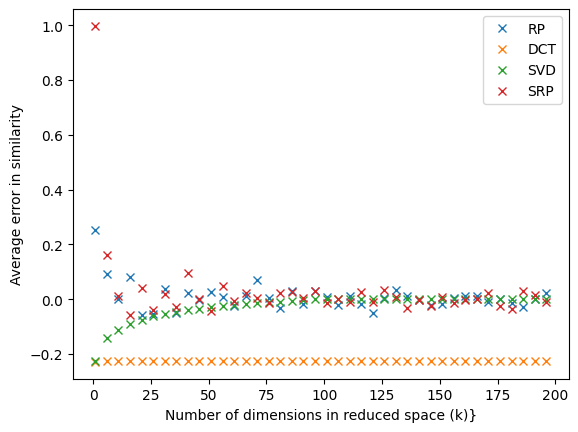

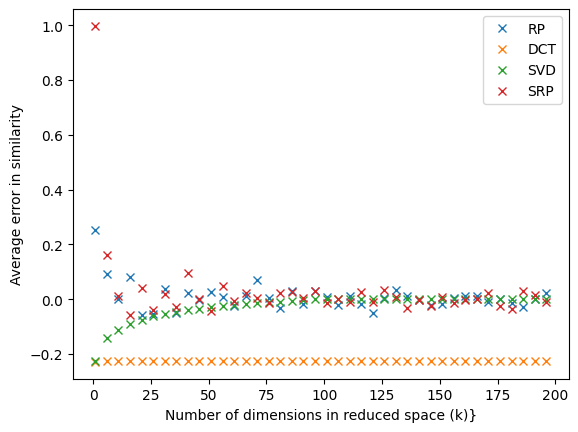

In [ ]:
plot_results([resultrp,resultdct,resultsvd,resultsrp])